In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
#from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#from sklearn.feature_selection import RFE
#from sklearn.svm import SVC
#from sklearn.multiclass import OneVsRestClassifier
#from sklearn.ensemble import BaggingClassifier

In [39]:
import xgboost as xgb
from xgboost import plot_importance

In [40]:
#train_data = pd.read_csv("C:/Users/Görkem/DrivenData/train_values.csv", delimiter=",")
#train_label = pd.read_csv("C:/Users/Görkem/DrivenData/train_labels.csv", delimiter=",")
train_data = pd.read_csv("C:/Users/Görkem/DrivenData/oversampled_X.csv", delimiter=",")
train_label = pd.read_csv("C:/Users/Görkem/DrivenData/oversampled_y.csv", delimiter=",")

In [41]:
train_data.shape

(444777, 69)

In [6]:
#train_data = train_data.sample(frac=.30)
#indices = train_data.index
#train_label = train_label.iloc[indices]

In [7]:
train_data.shape

(133433, 69)

In [42]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_label, test_size=0.2, random_state=42)

In [43]:
y_fulltrain_labels = train_label['damage_grade']
y_train_labels = y_train['damage_grade']
y_valid_labels = y_valid['damage_grade']

In [44]:
class Encoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X, y=None):
        return self
    def transform(self, X):
        Xt = X.copy()
        encoded = pd.get_dummies(Xt)
        return encoded

In [45]:
class ColumnDrop(BaseEstimator, TransformerMixin):
    def __init__(self, items):
        self.items = items
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Xt = X.copy()
        dropped_data = Xt.drop(self.items, axis=1)
        return dropped_data

In [46]:
drop_features = ['building_id', 'has_secondary_use_gov_office', 
'has_secondary_use_use_police', 'has_secondary_use_institution','has_secondary_use_health_post',
'has_secondary_use_school','has_secondary_use_industry','has_secondary_use_other','has_secondary_use_rental',
'has_secondary_use_agriculture','has_secondary_use_hotel','position','plan_configuration', 'ground_floor_type'
]

In [67]:
drop_features=[
'building_id',     
'has_secondary_use_rental',
'has_secondary_use_institution',
'has_secondary_use_school',
'has_secondary_use_industry',
'has_secondary_use_gov_office',
'has_secondary_use_use_police',
'plan_configuration_c',
'plan_configuration_f',
'plan_configuration_m',
'plan_configuration_n',
'plan_configuration_o',
'plan_configuration_s',
'plan_configuration_a',
'plan_configuration_d',
'plan_configuration_q',
'plan_configuration_u',]

In [68]:
column_drop = ColumnDrop(drop_features)
encoder = Encoder()
sca = StandardScaler()
#pca = PCA(n_components= 35)
classifier = xgb.XGBClassifier(
                                objective = 'multi:softmax',
                                learning_rate = 0.3, 
                                n_estimators = 200, 
                                max_depth = 10, 
                                n_jobs=-1, 
                                scale_pos_weight=1,
                                subsample = 0.8,
                                min_child_weight=3)
                                #colsample_bytree = 0.3)

#selector = RFE(classifier, n_features_to_select=15, step=1)

In [69]:
#("classifier", classifier)
#("Encoder", encoder)
#("rfe", selector)
pipe = Pipeline([("ColumnDrop", column_drop), ("Encoder", encoder), ("Scaler", sca), ("classifier", classifier)])

In [70]:
pipe.fit(X_train, y_train_labels)

Pipeline(steps=[('ColumnDrop',
                 ColumnDrop(items=['building_id', 'has_secondary_use_rental',
                                   'has_secondary_use_institution',
                                   'has_secondary_use_school',
                                   'has_secondary_use_industry',
                                   'has_secondary_use_gov_office',
                                   'has_secondary_use_use_police',
                                   'plan_configuration_c',
                                   'plan_configuration_f',
                                   'plan_configuration_m',
                                   'plan_configuration_n',
                                   'plan_configuration_o',
                                   'plan_configuration_s',
                                   'plan_configuration_a',
                                   'plan_configuration_d',
                                   'plan_configuration_q',
                              

In [71]:
y_pred = pipe.predict(X_valid)
score = f1_score(y_valid_labels, y_pred, average='micro')

In [72]:
print(score)

0.8149984261882279


In [53]:
#from itertools import compress
#rfe = pipe[3]
#df1 = column_drop.transform(X_train)
#features_list = df1.columns.to_list()
#arr = rfe.support_
#ans = list(compress(features_list, arr)) 
#print(ans)

In [54]:
# 200 estimator --> 0.7426 (best)
# 300 estimator --> 0.7417 (bad)
# 250 estimator --> 0.7424 (not the best nor the worst)
# *****************************************************

# 0.8 subsample --> 0.7436 --> 0.7426 in website

# 'count_families', 'has_secondary_use' dropped --> 0.7414

# standard_scaler --> 0.7436 in website , 0.74273325530976 in notebook

# position dropped --> 0.7421 in notebook

# 0.3 test size --> 0.7404 with dropped position
# 0.3 test size --> 0.7421 only building id dropped (bad)
# 0.4 test size --> 
# min_child_weight = 5 --> 0.7450 in notebook , 0.7434 in website

# grid_search with 3 cv , for min_child_weights [2,3,4] --> 3 is the best , score in notebook :0.7422, in website : 0.7444

# gamma 0.1 --> score in notebook :0.7426, 0.7434 in website
# many drop features --> 0.7409

# drop_features = ['building_id', 'has_secondary_use_gov_office', 'has_secondary_use_use_police'] --> 0.7437 notebook

# drop_features = ['building_id', 'has_secondary_use_gov_office', 
# 'has_secondary_use_use_police', 'has_secondary_use_institution'] --> 0.7442 notebook

# drop_features = ['building_id', 'has_secondary_use_gov_office', 
#'has_secondary_use_use_police', 'has_secondary_use_institution','has_secondary_use_health_post',
#'has_secondary_use_school','has_secondary_use_industry'] --> 0.7441 notebook ---> in website 0.7447

## Best drops and  0.50 fraction --> 0.7347659247889485

#drop_features = ['building_id', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_institution',
#'has_secondary_use_health_post','has_secondary_use_school','has_secondary_use_industry', 
#'position', 'plan_configuration', 'legal_ownership_status','has_secondary_use_hotel'
#,'has_secondary_use_rental']  --> 0.7450 notebook ---> in website 0.7442

#drop_features = ['building_id', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_institution',
#'has_secondary_use_health_post','has_secondary_use_school','has_secondary_use_industry', 
#'position', 'plan_configuration', 'legal_ownership_status','has_secondary_use_hotel'
#,'has_secondary_use_rental']  --> full data ---> in website 0.7456


In [55]:
#Best in website : Score --> 0.7447

'''
objective = 'multi:softmax',
learning_rate = 0.3, 
n_estimators = 200, 
max_depth = 10, 
n_jobs=-1, 
scale_pos_weight=1,
subsample = 1,
min_child_weight=3)
drop_features = ['building_id', 'has_secondary_use_gov_office', 
'has_secondary_use_use_police', 'has_secondary_use_institution','has_secondary_use_health_post',
'has_secondary_use_school','has_secondary_use_industry'] 
'''

#Best in notebook : Score --> 0.7454

'''
objective = 'multi:softmax',
learning_rate = 0.3, 
n_estimators = 200, 
max_depth = 10, 
n_jobs=-1, 
scale_pos_weight=1,
subsample = 1,
min_child_weight=3)
drop_features = ['building_id']
'''

"\nobjective = 'multi:softmax',\nlearning_rate = 0.3, \nn_estimators = 200, \nmax_depth = 10, \nn_jobs=-1, \nscale_pos_weight=1,\nsubsample = 1,\nmin_child_weight=3)\ndrop_features = ['building_id']\n"

In [56]:
test_data = pd.read_csv("C:/Users/Görkem/DrivenData/test_values.csv", delimiter=",")
test_data = pd.get_dummies(test_data)

In [57]:
y_test_pred = pipe.predict(test_data)

In [58]:
building_id = test_data['building_id']

submission_df = pd.DataFrame({'building_id': building_id, 'damage_grade':y_test_pred}) 

In [59]:
submission_df.to_csv('nofraction_oversampled.csv', index=False)

In [60]:
tmp = column_drop.transform(X_train)

tmp = encoder.transform(tmp)

for name, importance in zip(tmp.columns, pipe[3].feature_importances_):
    print(name, " - ",importance)

geo_level_1_id  -  0.011531604
geo_level_2_id  -  0.0044163745
geo_level_3_id  -  0.0031429972
count_floors_pre_eq  -  0.009902438
age  -  0.0042712633
area_percentage  -  0.002296683
height_percentage  -  0.0029776634
has_superstructure_adobe_mud  -  0.008895887
has_superstructure_mud_mortar_stone  -  0.024611551
has_superstructure_stone_flag  -  0.013421787
has_superstructure_cement_mortar_stone  -  0.0086629
has_superstructure_mud_mortar_brick  -  0.009022952
has_superstructure_cement_mortar_brick  -  0.009218795
has_superstructure_timber  -  0.0058313785
has_superstructure_bamboo  -  0.0041653183
has_superstructure_rc_non_engineered  -  0.004854266
has_superstructure_rc_engineered  -  0.0058027455
has_superstructure_other  -  0.003956928
count_families  -  0.0045001847
has_secondary_use  -  0.00554491
has_secondary_use_agriculture  -  0.0035856948
has_secondary_use_hotel  -  0.0025104142
has_secondary_use_rental  -  0.0025511598
has_secondary_use_school  -  0.0016539991
has_seconda

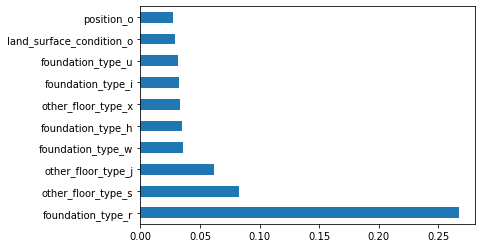

In [61]:
feat_importances = pd.Series(pipe[3].feature_importances_, index = tmp.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

[Text(0, 0, 'geo_level_1_id'),
 Text(0, 0, 'geo_level_2_id'),
 Text(0, 0, 'geo_level_3_id'),
 Text(0, 0, 'count_floors_pre_eq'),
 Text(0, 0, 'age'),
 Text(0, 0, 'area_percentage'),
 Text(0, 0, 'height_percentage'),
 Text(0, 0, 'has_superstructure_adobe_mud'),
 Text(0, 0, 'has_superstructure_mud_mortar_stone'),
 Text(0, 0, 'has_superstructure_stone_flag'),
 Text(0, 0, 'has_superstructure_cement_mortar_stone'),
 Text(0, 0, 'has_superstructure_mud_mortar_brick'),
 Text(0, 0, 'has_superstructure_cement_mortar_brick'),
 Text(0, 0, 'has_superstructure_timber'),
 Text(0, 0, 'has_superstructure_bamboo'),
 Text(0, 0, 'has_superstructure_rc_non_engineered'),
 Text(0, 0, 'has_superstructure_rc_engineered'),
 Text(0, 0, 'has_superstructure_other'),
 Text(0, 0, 'count_families'),
 Text(0, 0, 'has_secondary_use'),
 Text(0, 0, 'has_secondary_use_agriculture'),
 Text(0, 0, 'has_secondary_use_hotel'),
 Text(0, 0, 'has_secondary_use_rental'),
 Text(0, 0, 'has_secondary_use_school'),
 Text(0, 0, 'has_sec

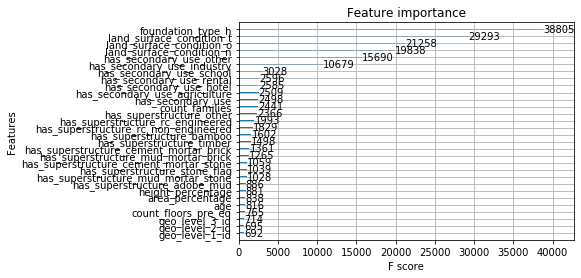

In [62]:
plot_importance(pipe[3], max_num_features=30).set_yticklabels(tmp.columns)

In [127]:
model = pipe[3]

In [129]:
from numpy import sort
thresholds = sort(model.feature_importances_)
thresholds

array([0.00780494, 0.00853913, 0.00870948, 0.01040658, 0.0104573 ,
       0.01059105, 0.01104112, 0.01123249, 0.011318  , 0.0115955 ,
       0.01190584, 0.01227569, 0.01245403, 0.01252087, 0.01264828,
       0.01265488, 0.01327561, 0.01333957, 0.01338832, 0.01376056,
       0.01414075, 0.01452884, 0.01495107, 0.01707238, 0.01749728,
       0.01789645, 0.0186174 , 0.01892039, 0.01901534, 0.02018123,
       0.0206739 , 0.02095972, 0.0292342 , 0.03354678, 0.03421518,
       0.03623824, 0.04782698, 0.05003062, 0.32453406], dtype=float32)

In [ ]:
from numpy import sort
from sklearn.feature_selection import SelectFromModel

thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

In [138]:
xgb.cv?

In [139]:
xgb.train?